In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
# Import Modules
from keras.models import Sequential,Model
from keras.layers import Input, LSTM, Bidirectional,Dense,Conv1D, Conv2D, MaxPooling1D,MaxPool2D, Flatten, Dropout,TimeDistributed,Multiply
from keras import optimizers

from keras.layers.core import *
from keras.models import *
from utils import *

# 1. Preprocess

## Load data

In [2]:
BYD = pd.read_excel("BYD.xls")

In [13]:
row_dataset = BYD.set_index('Dates') 
dataset = row_dataset.dropna()
dataset.iloc[:,1]

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [15]:
def on_balance_volume_creation(stock_df):
    
    # Adding of on balance volume to dataframe
    
    new_df = pd.DataFrame({})

    new_df = stock_df[['share_pricing']].copy()


    new_balance_volume = [0]
    tally = 0

    #Adding the volume if the 
    for i in range(1, len(new_df)):
        if (stock_df['share_pricing'][i] > stock_df['share_pricing'][i - 1]):
            tally += stock_df.iloc[:,1][i]
        elif (stock_df['share_pricing'][i] < stock_df['share_pricing'][i - 1]):
            tally -= stock_df.iloc[:,1][i]
        new_balance_volume.append(tally)

    new_df['On_Balance_Volume'] = new_balance_volume
    minimum = min(new_df['On_Balance_Volume'])

    new_df['On_Balance_Volume'] = new_df['On_Balance_Volume'] - minimum
    new_df['On_Balance_Volume'] = (new_df['On_Balance_Volume']+1).transform(np.log)

    return new_df


new_df = on_balance_volume_creation(dataset)
new_df

,share_pricing,On_Balance_Volume
Dates,,
2012-01-03,18.12,15.799191
2012-01-04,17.84,15.034719
2012-01-05,17.80,14.668798
2012-01-06,17.06,0.000000
2012-01-09,18.24,15.247662
...,...,...
2022-06-24,310.20,20.717655
2022-06-27,318.00,20.725900
2022-06-28,331.40,20.737555


## Train-test spllit

In [59]:
train = new_df[:2000]
test = new_df[2000:]
len(train)

2000

In [61]:
def add_technical_indicators(data,days=21,smoothing=2):
    # Calculated EMA
    ema = [sum(data['share_pricing'][:days]) / days]
    for price in data['share_pricing'][days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    zeros = np.zeros(20)
    ema1 = np.append(zeros,ema)
    data['EMA'] = ema1.copy()
    bb = np.zeros(len(data))
    data['bb_upper'] = bb.copy()
    data['bb_lower'] = bb.copy()
   
    #Filling of missing data as Bollinger Bands is based on a 21 day EMA
    std =  data['share_pricing'].rolling(21).std()
    
    for i in range(20,len(data)-days):
        higher = data['EMA'][i] + 2 * std[i]
        lower = data['EMA'][i] - 2 * std[i]
        data['bb_upper'][i] = higher
        data['bb_lower'][i] = lower

    return data

train = add_technical_indicators(train)
test = add_technical_indicators(test)

/var/folders/dg/2kry1x8x3n5fr3_r_zjpf1f80000gn/T/ipykernel_6988/3701637303.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EMA'] = ema1.copy()
/var/folders/dg/2kry1x8x3n5fr3_r_zjpf1f80000gn/T/ipykernel_6988/3701637303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bb_upper'] = bb.copy()
/var/folders/dg/2kry1x8x3n5fr3_r_zjpf1f80000gn/T/ipykernel_6988/3701637303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [53]:
train

,share_pricing,On_Balance_Volume,EMA,bb_upper,bb_lower
Dates,,,,,
2012-01-03,18.12,15.799191,0.000000,0.0,0.0
2012-01-04,17.84,15.034719,0.000000,0.0,0.0
2012-01-05,17.80,14.668798,0.000000,0.0,0.0
2012-01-06,17.06,0.000000,0.000000,0.0,0.0
2012-01-09,18.24,15.247662,0.000000,0.0,0.0
...,...,...,...,...,...
2020-02-25,52.00,20.176027,47.175951,0.0,0.0
2020-02-26,52.20,20.204301,47.632682,0.0,0.0
2020-02-27,51.20,20.190868,47.956984,0.0,0.0


## Clean data

In [292]:
df_train = train[(train[['EMA','bb_upper','bb_lower']] != 0).all(axis=1)]
df_test = test[(test[['EMA','bb_upper','bb_lower']] != 0).all(axis=1)]
df_train

,share_pricing,On_Balance_Volume,EMA,bb_upper,bb_lower
Dates,,,,,
2012-02-03,24.65,18.078600,21.351429,26.514661,16.188196
2012-02-06,24.90,18.124567,21.674026,26.836508,16.511544
2012-02-07,25.90,18.216312,22.058205,27.221877,16.894534
2012-02-08,28.35,18.391067,22.630187,28.097802,17.162571
2012-02-09,27.25,18.314107,23.050170,28.270628,17.829712
...,...,...,...,...,...
2020-01-23,46.35,20.059555,43.014562,51.172112,34.857012
2020-01-24,46.20,20.052676,43.304147,51.395448,35.212847
2020-01-29,43.20,20.036707,43.294679,51.065387,35.523971


## Normalization

In [259]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(df_train)
scaler2.fit(df_test)
train_scaled = scaler1.transform(df_train)
test_scaled = scaler2.transform(df_test)
np.allclose(df_train, scaler1.inverse_transform(train_scaled))
np.allclose(df_test, scaler2.inverse_transform(test_scaled))

True

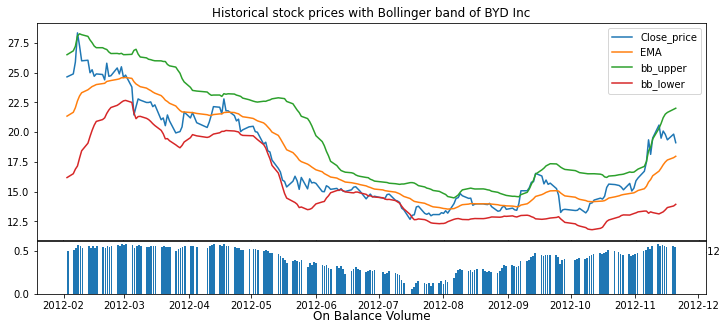

In [260]:
top_plt = plt.subplot2grid((40,70), (0, 0), rowspan=20, colspan=70)
top_plt.plot(df_train[["share_pricing",'EMA','bb_upper','bb_lower']][:200])
plt.legend(["Close_price",'EMA','bb_upper','bb_lower'])
plt.title('Historical stock prices with Bollinger band of BYD Inc')
bottom_plt = plt.subplot2grid((40,70), (20,0), rowspan=5, colspan=70)
bottom_plt.bar(df_train.index[:200], train_scaled[:,1][:200])
plt.title('On Balance Volume', y=-0.60)
plt.gcf().set_size_inches(12,8)

### Feature, Target split

In [261]:
def construct_X(data, ntimes, step):
    X_train_concat = []
    for i in range(len(data) - (ntimes+1)*step):
        X_train_concat.append(data[i:i+ntimes*step])
    return np.array(X_train_concat)

def construct_Y(data, ntimes, step):
    y_train_concat = []
    for i in range(len(data) - (ntimes+1)*step):
        y_train_concat.append(data['share_pricing'][i+ntimes])
    y = np.array(y_train_concat)
    y = np.reshape(y,[y.shape[0],1])
    return np.array(y)

In [262]:
x_train = construct_X(train_scaled,21,1)
y_train_noscaled = construct_Y(df_train,21,1)
x_test = construct_X(test_scaled,21,1)
y_test_noscaled = construct_Y(df_test,21,1)

scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler3.fit(y_train_noscaled)
y_train = scaler3.transform(y_train_noscaled)

scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler4.fit(y_test_noscaled)
y_test = scaler4.transform(y_test_noscaled)

np.allclose(y_train_noscaled, scaler3.inverse_transform(y_train))
np.allclose(y_test_noscaled, scaler4.inverse_transform(y_test))

True

In [266]:
print(x_train.shape,y_train.shape)

(1937, 21, 5) (1937, 1)


# 2. Comparing NN models on index prediction 

* LSTM for indicators prediction

In [267]:
def lstm_model(X_train, y_train, lookback):
    tf.random.set_seed(20)
    np.random.seed(10)
    
    lstm_input = Input(shape=(lookback,5), name='lstm_input')
    inputs = LSTM(128, name='first_layer')(lstm_input)
    output = Dense(1, activation='sigmoid',name='dense_layer')(inputs)
    model = Model(inputs=lstm_input, outputs=output)
 
    return model

In [268]:
lstm = lstm_model(x_train, y_train, 21)
lstm.summary()
adam = optimizers.Adam(learning_rate = 0.005)
# Compile 
lstm.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
history = lstm.fit(x_train, y_train,batch_size=16, epochs=100,validation_split=0.2)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 21, 5)]           0         
                                                                 
 first_layer (LSTM)          (None, 128)               68608     
                                                                 
 dense_layer (Dense)         (None, 1)                 129       
                                                                 
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________
Training model...
Epoch 1/100
97/97 [==============================] - 3s 14ms/step - loss: 0.0084 - val_loss: 0.0015
Epoch 2/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/100
97/97 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.2667e-04

97/97 [==============================] - 1s 11ms/step - loss: 4.0973e-04 - val_loss: 3.4113e-04
Epoch 70/100
97/97 [==============================] - 1s 11ms/step - loss: 3.9808e-04 - val_loss: 3.3767e-04
Epoch 71/100
97/97 [==============================] - 1s 12ms/step - loss: 3.8380e-04 - val_loss: 4.5865e-04
Epoch 72/100
97/97 [==============================] - 1s 13ms/step - loss: 4.0548e-04 - val_loss: 4.0732e-04
Epoch 73/100
97/97 [==============================] - 1s 12ms/step - loss: 3.7837e-04 - val_loss: 3.6303e-04
Epoch 74/100
97/97 [==============================] - 1s 12ms/step - loss: 3.6014e-04 - val_loss: 4.0070e-04
Epoch 75/100
97/97 [==============================] - 1s 12ms/step - loss: 3.7362e-04 - val_loss: 3.5846e-04
Epoch 76/100
97/97 [==============================] - 1s 13ms/step - loss: 3.5812e-04 - val_loss: 3.4112e-04
Epoch 77/100
97/97 [==============================] - 1s 13ms/step - loss: 4.0378e-04 - val_loss: 4.1574e-04
Epoch 78/100
97/97 [============

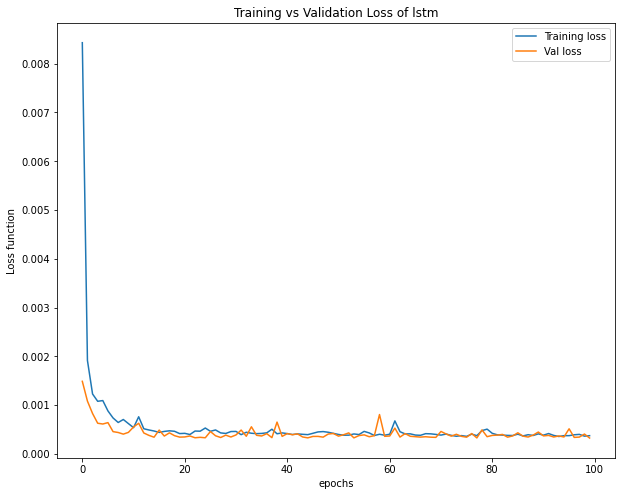

In [269]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"], label = "Val loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss of lstm")
plt.legend()
plt.show()

In [270]:
y_pred_train_lstm = lstm.predict(x_train)
y_pred_test_lstm = lstm.predict(x_test)


16/16 [==============================] - 0s 5ms/step


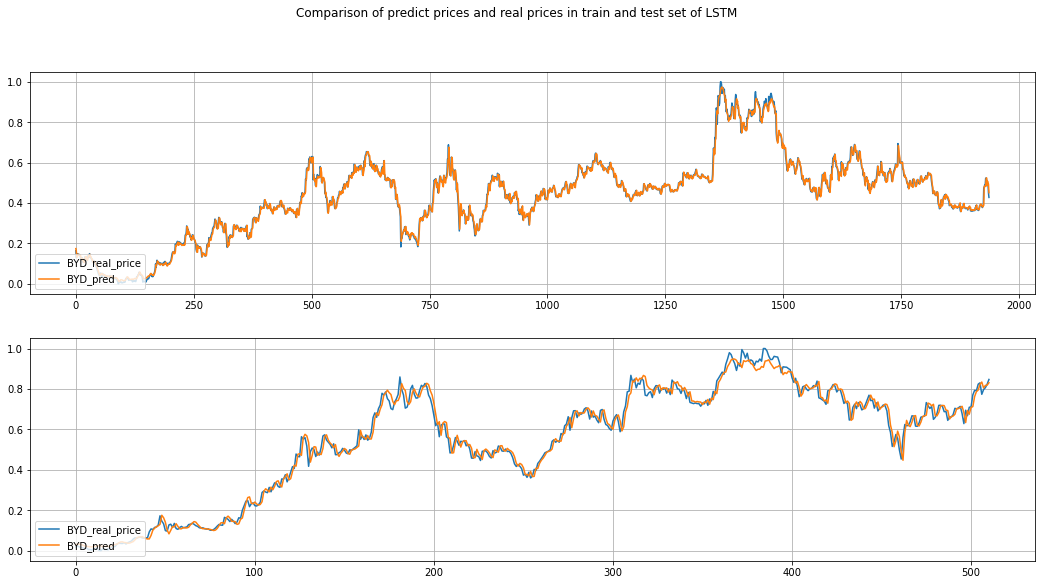

In [271]:
fig, ax = plt.subplots(2, figsize=[18,9])
fig.suptitle('Comparison of predict prices and real prices in train and test set of LSTM')
ax[0].plot(y_train[:,0])
ax[0].plot(y_pred_train_lstm[:,0])
ax[0].grid()
ax[0].legend(['BYD_real_price','BYD_pred'],loc='lower left')
ax[1].plot(y_test[:,0])
ax[1].plot(y_pred_test_lstm[:,0])
ax[1].grid()
ax[1].legend(['BYD_real_price','BYD_pred'],loc='lower left')

In [272]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
y_pred_train_lstm1 = scaler3.inverse_transform(y_pred_train_lstm)
y_pred_test_lstm1 = scaler4.inverse_transform(y_pred_test_lstm)

rmse1 = sqrt(mean_squared_error(y_train_noscaled, y_pred_train_lstm1))
rmse2 = sqrt(mean_squared_error(y_test_noscaled, y_pred_test_lstm1))
r2_train = r2_score(y_train_noscaled,y_pred_train_lstm1)
r2_test = r2_score(y_test_noscaled,y_pred_test_lstm1)
print(rmse1,rmse2,r2_train,r2_test)

1.2275213109120122 8.410959940901186 0.9916922181177735 0.9874020080920569


* CNN for indicators prediction

In [273]:
def CNN_model(seq_len=21, n_features=5, n_filters=(8,8,8), droprate=0.1):
    "2D-CNNpred model according to the paper"
    model = Sequential([
        Input(shape=(seq_len, 5, 1)),
        Conv2D(n_filters[0], kernel_size=(1, n_features), activation="relu"),
        Conv2D(n_filters[1], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Conv2D(n_filters[2], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
    return model

In [274]:
CNN = CNN_model()
CNN.summary()
adam = optimizers.Adam(learning_rate = 0.005)
# Compile 
CNN.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
history = CNN.fit(x_train, y_train,batch_size=16, epochs=100,validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 1, 8)          48        
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 1, 8)          200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 1, 8)          0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 1, 8)           200       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 1, 8)          0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 24)               

Epoch 67/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 68/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 69/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 70/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 71/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 72/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 73/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 74/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 75/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 76/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0019


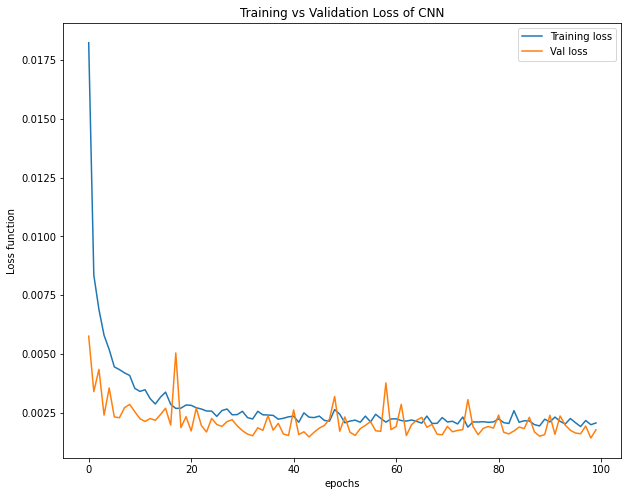

In [275]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"], label = "Val loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss of CNN")
plt.legend()
plt.show()

In [276]:
y_pred_train_CNN = CNN.predict(x_train)
y_pred_CNN = CNN.predict(x_test)


16/16 [==============================] - 0s 2ms/step


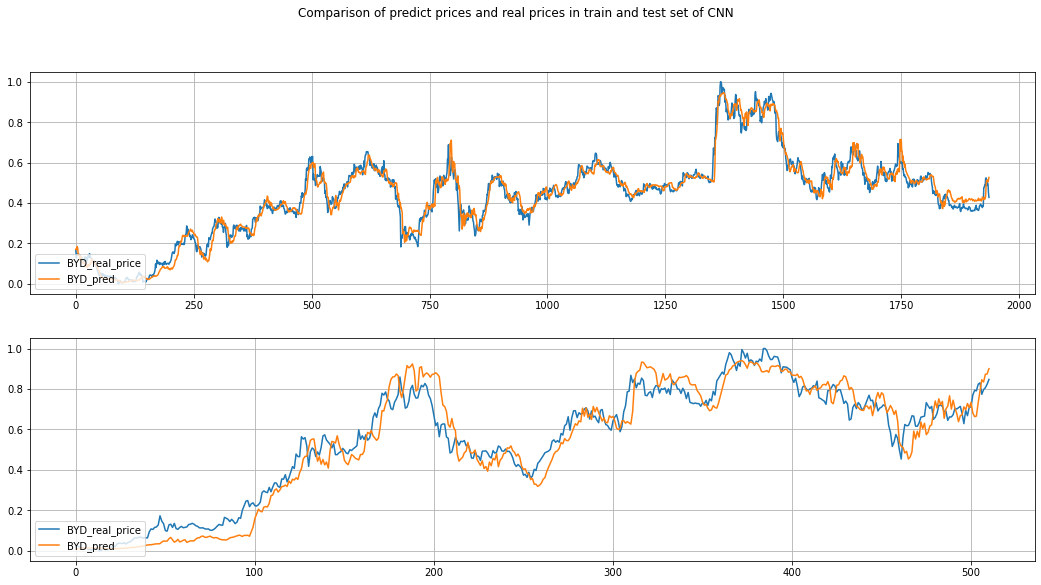

In [277]:
fig, ax = plt.subplots(2, figsize=[18,9])
fig.suptitle('Comparison of predict prices and real prices in train and test set of CNN')
ax[0].plot(y_train[:,0])
ax[0].plot(y_pred_train_CNN[:,0])
ax[0].grid()
ax[0].legend(['BYD_real_price','BYD_pred'],loc='lower left')
ax[1].plot(y_test[:,0])
ax[1].plot(y_pred_CNN[:,0])
ax[1].grid()
ax[1].legend(['BYD_real_price','BYD_pred'],loc='lower left')

In [279]:
y_pred_train_CNN1 = scaler3.inverse_transform(y_pred_train_CNN)
y_pred_CNN1 = scaler4.inverse_transform(y_pred_CNN)

rmse_CNN = sqrt(mean_squared_error(y_train_noscaled, y_pred_train_CNN1))
rmse_CNN1 = sqrt(mean_squared_error(y_test_noscaled, y_pred_CNN1))
r2_CNN = r2_score(y_train_noscaled,y_pred_train_CNN1)
r2_CNN1 = r2_score(y_test_noscaled,y_pred_CNN1)
print(rmse_CNN,rmse_CNN1,r2_CNN,r2_CNN1)

2.659594083944305 21.08076687512415 0.9610006183667843 0.9208623759880235


* CNN+LSTM 
https://vermaabhi23.github.io/publication/2019CCWC1.pdf

In [280]:
def CNN_LSTM():
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=1,padding="causal",activation="relu",
                               input_shape=(21,5)),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
        tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1)
    ])
    return model

In [281]:
CNN_LSTM_model = CNN_LSTM()
adam = optimizers.Adam(learning_rate = 0.005)
# Compile 
CNN_LSTM_model.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
history = CNN_LSTM_model.fit(x_train, y_train,batch_size=16, epochs=100,validation_split=0.2)
CNN_LSTM_model.summary()

Training model...
Epoch 1/100
97/97 [==============================] - 10s 19ms/step - loss: 0.0353 - val_loss: 0.0028
Epoch 2/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0102 - val_loss: 0.0018
Epoch 3/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0085 - val_loss: 0.0110
Epoch 4/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 5/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 6/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 7/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 8/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 9/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 10/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0038 - val_l

97/97 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 6.2863e-04
Epoch 82/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 7.2964e-04
Epoch 83/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 7.8087e-04
Epoch 84/100
97/97 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 85/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 8.2438e-04
Epoch 86/100
97/97 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 7.5536e-04
Epoch 87/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 88/100
97/97 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 89/100
97/97 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 7.3188e-04
Epoch 90/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0017

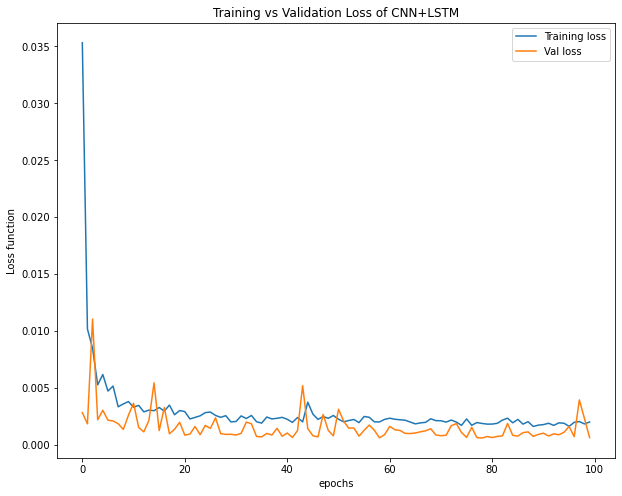

In [282]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"], label = "Val loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss of CNN+LSTM")
plt.legend()
plt.show()

In [284]:
y_pred_CNN_LSTM_train = CNN_LSTM_model.predict(x_train)
y_pred_CNN_LSTM_test = CNN_LSTM_model.predict(x_test)

y_pred_CNN_LSTM_train1 = scaler3.inverse_transform(y_pred_CNN_LSTM_train)
y_pred_CNN_LSTM_test1 = scaler4.inverse_transform(y_pred_CNN_LSTM_test)

rmse_CNNlstm = sqrt(mean_squared_error(y_train_noscaled, y_pred_CNN_LSTM_train1))
rmse_CNNlstm1 = sqrt(mean_squared_error(y_test_noscaled, y_pred_CNN_LSTM_test1))
r2_CNNlstm = r2_score(y_train_noscaled,y_pred_CNN_LSTM_train1)
r2_CNNlstm1 = r2_score(y_test_noscaled,y_pred_CNN_LSTM_test1) 
print(rmse_CNNlstm,rmse_CNNlstm1,r2_CNNlstm,r2_CNNlstm1)

16/16 [==============================] - 0s 3ms/step
1.7027321509503113 10.169121210343286 0.9840147409948969 0.9815847743945169


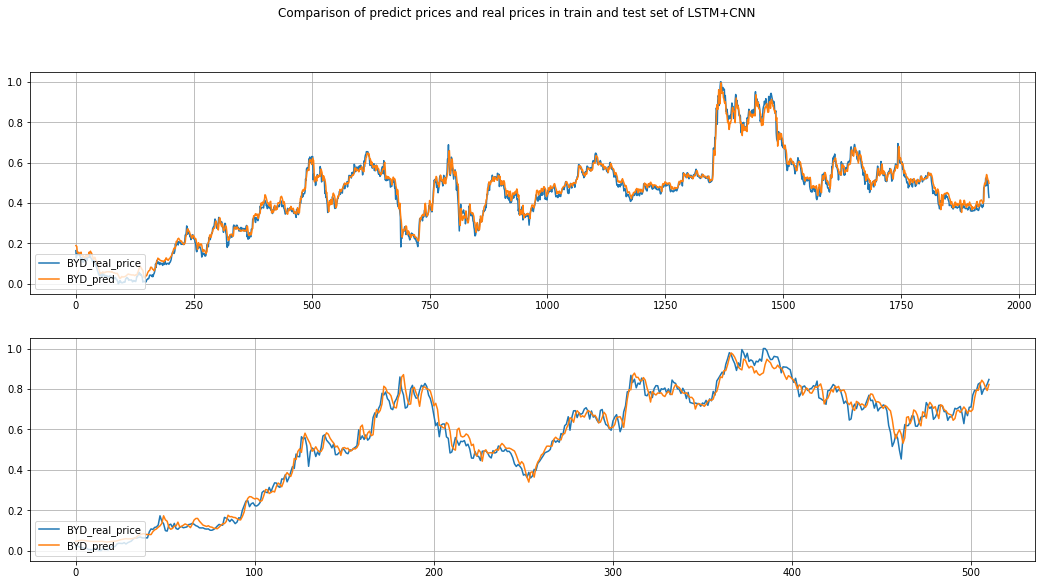

In [285]:
fig, ax = plt.subplots(2, figsize=[18,9])
fig.suptitle('Comparison of predict prices and real prices in train and test set of LSTM+CNN')
ax[0].plot(y_train[:,0])
ax[0].plot(y_pred_CNN_LSTM_train[:,0])
ax[0].grid()
ax[0].legend(['BYD_real_price','BYD_pred'],loc='lower left')
ax[1].plot(y_test[:,0])
ax[1].plot(y_pred_CNN_LSTM_test[:,0])
ax[1].grid()
ax[1].legend(['BYD_real_price','BYD_pred'],loc='lower left')

* lstm+attention

In [286]:

def attention_3d_block(inputs, single_attention_vector=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = 21
    input_dim = 3
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x:mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model(INPUT_DIMS = 5,TIME_STEPS = 21,lstm_units = 64):
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [287]:
atten = attention_model()
adam = optimizers.Adam(learning_rate = 0.005)
# Compile 
atten.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
history = atten.fit(x_train, y_train,batch_size=16, epochs=50,validation_split=0.2)
atten.summary()

Training model...
Epoch 1/50
97/97 [==============================] - 4s 15ms/step - loss: 0.0120 - val_loss: 0.0043
Epoch 2/50
97/97 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 3/50
97/97 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 7.1224e-04
Epoch 4/50
97/97 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 8.4361e-04
Epoch 5/50
97/97 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 5.6308e-04
Epoch 6/50
97/97 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 5.2382e-04
Epoch 7/50
97/97 [==============================] - 1s 9ms/step - loss: 9.6024e-04 - val_loss: 7.2792e-04
Epoch 8/50
97/97 [==============================] - 1s 9ms/step - loss: 7.8276e-04 - val_loss: 5.0284e-04
Epoch 9/50
97/97 [==============================] - 1s 9ms/step - loss: 8.5354e-04 - val_loss: 0.0010
Epoch 10/50
97/97 [==============================] - 1s 10ms/st

In [291]:
y_pred_atten_train = atten.predict(x_train)
y_pred_atten_test = atten.predict(x_test)
y_pred_atten_train1 = scaler3.inverse_transform(y_pred_atten_train)
y_pred_atten_test1 = scaler4.inverse_transform(y_pred_atten_test)

rmse_atten = sqrt(mean_squared_error(y_train_noscaled, y_pred_atten_train1))
rmse_atten1 = sqrt(mean_squared_error(y_test_noscaled, y_pred_atten_test1))
r2_atten = r2_score(y_train_noscaled,y_pred_atten_train1)
r2_atten1 = r2_score(y_test_noscaled,y_pred_atten_test1) 
print(rmse_atten,rmse_atten1,r2_atten,r2_atten1)

16/16 [==============================] - 0s 5ms/step
1.3272629069218136 8.034863784574664 0.9902872788780124 0.9885034579262764


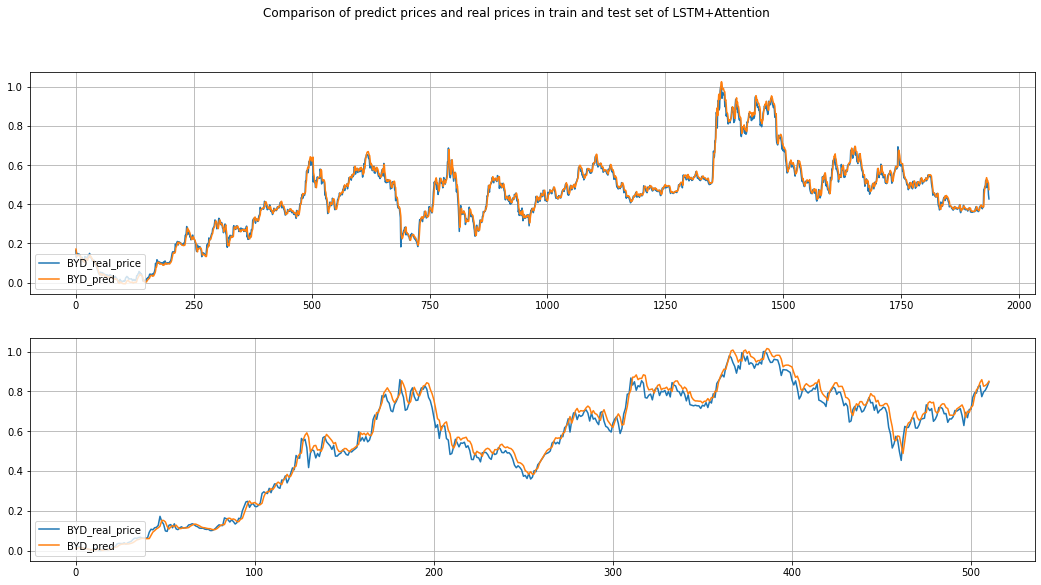

In [288]:
fig, ax = plt.subplots(2, figsize=[18,9])
fig.suptitle('Comparison of predict prices and real prices in train and test set of LSTM+Attention')
ax[0].plot(y_train[:,0])
ax[0].plot(y_pred_atten_train[:,0])
ax[0].grid()
ax[0].legend(['BYD_real_price','BYD_pred'],loc='lower left')
ax[1].plot(y_test[:,0])
ax[1].plot(y_pred_atten_test[:,0])
ax[1].grid()
ax[1].legend(['BYD_real_price','BYD_pred'],loc='lower left')